# 1. Data

## Collect / generate data 

In [1]:
import numpy as np

def gaussian_generator(mean_x1, mean_x2, cov_x1, cov_x2, num_samples):

    return np.random.multivariate_normal(mean_x1, cov_x1, num_samples), \
           np.random.multivariate_normal(mean_x2, cov_x2, num_samples)

In [2]:
def generate_gaussian_samples(gaussian_length, rho, num_samples):
    mean_x1 = np.zeros([gaussian_length])
    mean_x2 = np.ones([gaussian_length])

    cov_x1 = np.zeros([gaussian_length, gaussian_length])
    cov_x2 = np.zeros([gaussian_length, gaussian_length])
    for i in range(gaussian_length):
        cov_x1[i][i] = rho
        cov_x2[i][i] = rho

    x_samples, y_samples = gaussian_generator(mean_x1, mean_x2, cov_x1, cov_x2, num_samples)

    return x_samples, y_samples

## Split data for training, validation, and test

The real test data may not exist when you develop a model

In [3]:
n_train = 10000
n_val = 2000
n_test = 2000

x1_samples_train, x2_samples_train = generate_gaussian_samples(gaussian_length=100, rho=0.05, num_samples=n_train)
x1_samples_val, x2_samples_val = generate_gaussian_samples(gaussian_length=100, rho=0.5, num_samples=n_val)
x1_samples_test, x2_samples_test = generate_gaussian_samples(gaussian_length=100, rho=0.5, num_samples=n_test)

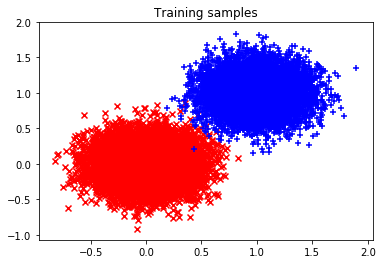

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x1_samples_train[:,0], x1_samples_train[:,1], c='r', marker="x")
plt.scatter(x2_samples_train[:,0], x2_samples_train[:,1], c='b', marker="+")
plt.title("Training samples")
plt.show()

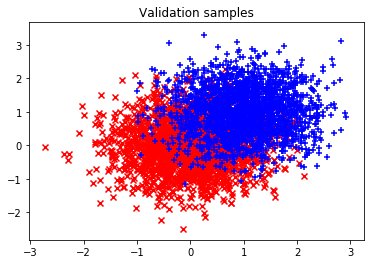

In [5]:
plt.scatter(x1_samples_val[:,0], x1_samples_val[:,1], c='r', marker="x")
plt.scatter(x2_samples_val[:,0], x2_samples_val[:,1], c='b', marker="+")
plt.title("Validation samples")
plt.show()

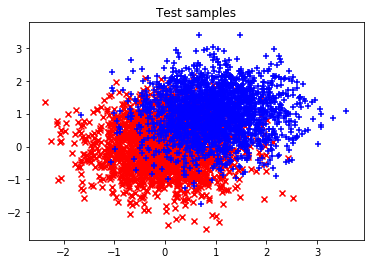

In [6]:
plt.scatter(x1_samples_test[:,0], x1_samples_test[:,1], c='r', marker="x")
plt.scatter(x2_samples_test[:,0], x2_samples_test[:,1], c='b', marker="+")
plt.title("Test samples")
plt.show()

## Customize PyTorch dataset and dataloader 

Bottom line: don't let your GPU wait for data 

In [7]:
import torch
from torch.utils.data import Dataset

class GaussianSampleDataset(Dataset):

    def __init__(self, x1_samples, x2_samples):
        self.x1_samples = torch.tensor(x1_samples, dtype=torch.float32)
        self.x2_samples = torch.tensor(x2_samples, dtype=torch.float32)
        self.input_samples = torch.cat((self.x1_samples, self.x2_samples), dim=0)
        
        self.x1_labels = torch.zeros((self.x1_samples.shape[0],1))
        self.x2_labels = torch.ones((self.x2_samples.shape[0],1))
        self.labels = torch.cat((self.x1_labels, self.x2_labels), dim=0)

    def __len__(self):
        return self.input_samples.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_sample = self.input_samples[idx, :].unsqueeze(-1)
        label = self.labels[idx].unsqueeze(-1)

        return input_sample, label

In [8]:
from torch.utils.data import DataLoader

train_dataset = GaussianSampleDataset(x1_samples_train, x2_samples_train)
train_dataloader = DataLoader(train_dataset, shuffle=True,
                              batch_size=64, num_workers=8,
                              pin_memory=True)

val_dataset = GaussianSampleDataset(x1_samples_val, x2_samples_val)
val_dataloader = DataLoader(val_dataset, shuffle=False,
                              batch_size=64, num_workers=8,
                              pin_memory=True)

test_dataset = GaussianSampleDataset(x1_samples_test, x2_samples_test)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                              batch_size=64, num_workers=8,
                              pin_memory=True)

# 2. Model Development

In [9]:
import torch.nn as nn

def make_mlp(input_dim, hidden_dims, output_dim=1, activation='relu'):
    """Create a mlp from the configurations.
    """
    activation = {
        'relu': nn.ReLU
    }[activation]

    num_hidden_layers = len(hidden_dims)

    seq = [nn.Linear(input_dim, hidden_dims[0]), activation()]
    for i in range(num_hidden_layers-1):
        seq += [nn.Linear(hidden_dims[i], hidden_dims[i+1]), activation()]
    seq += [nn.Linear(hidden_dims[-1], output_dim)]

    return nn.Sequential(*seq)


class Discriminator(nn.Module):
    """A neural network discriminator.
    """
    def __init__(self, sample_length, hidden_dims):
        super(Discriminator, self).__init__()

        self.sample_length = sample_length
        self.hidden_dims = hidden_dims
        self.mlp = make_mlp(sample_length, hidden_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.reshape(x, (x.size()[0], 1, x.size()[-1]))
        logit = self.mlp(x)

        return logit

    def save_pretrained(self, save_directory):
        """ Save the discriminator with its configuration file to a directory, 
            so that it can be re-loaded 
            using the `from_pretrained(save_directory)` class method.
        """
        assert os.path.isdir(save_directory), \
            "Saving path should be a directory where the model and configuration can be saved"

        # Only save the model it-self if we are using distributed training
        model_to_save = self.module if hasattr(self, 'module') else self

        # If we save using the predefined names, we can load using `from_pretrained`
        output_model_file = os.path.join(save_directory, 'pytorch_discriminator.bin')
        torch.save(model_to_save.state_dict(), output_model_file)

    @classmethod
    def from_pretrained(cls, pretrained_model_path, **kwargs):
        """ Re-load a trained model.
        """		
        sample_length = kwargs.pop('sample_length', 20)
        hidden_dims = kwargs.pop('hidden_dims', [256,256])

        # Specify the pretrained discriminator path
        if os.path.isdir(pretrained_model_path):
            archive_file = os.path.join(pretrained_model_path, 'pytorch_discriminator.bin')
        else:
            raise Exception('Please provide a directory to load the model from, currently given',
                pretrained_model_path)

        #print("Loading the discriminator model")
        # Instantiate the model
        model = cls(sample_length=sample_length, 
                    hidden_dims=hidden_dims)
        #print("Instantiated model summary: {}".format(model))

        state_dict = torch.load(archive_file, map_location='cpu')

        # Convert old format to new format if needed from a PyTorch state_dict
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if 'gamma' in key:
                new_key = key.replace('gamma', 'weight')
            if 'beta' in key:
                new_key = key.replace('beta', 'bias')
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)

        # Load from a PyTorch state_dict
        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')

        load(model)
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
                                model.__class__.__name__, "\n\t".join(error_msgs)))

        return model

# 3. Run (train/evaluate/test) the model

In [10]:
assert torch.cuda.is_available(), "No GPU/CUDA is detected!"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Instantiate the model

In [11]:
classifier = Discriminator(sample_length=100, hidden_dims=[1024,1024])
classifier.to(device)

Discriminator(
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [12]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm

param_optimizer = list(classifier.named_parameters())
optimizer_parameters = classifier.parameters()
optimizer = Adam(optimizer_parameters, lr=1e-5)

BCE_loss_criterion = BCEWithLogitsLoss()

num_train_epochs = 20
tr_losses = []
val_losses = []
test_losses = []

for epoch in range(num_train_epochs):
    tr_epoch_loss = 0.0
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    classifier.train()
    for step, batch in enumerate(epoch_iterator, 0):
        optimizer.zero_grad()

        batch = tuple(t.to(device=device, non_blocking=True) for t in batch)
        input_samples, labels = batch

        output_logits = classifier(input_samples)
        loss = BCE_loss_criterion(output_logits, labels)
        loss.backward()
        optimizer.step()

        tr_epoch_loss += loss.item()

    val_epoch_loss = 0.0
    classifier.eval()
    for step, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device=device, non_blocking=True) for t in batch)
        input_samples, labels = batch

        output_logits = classifier(input_samples)
        loss = BCE_loss_criterion(output_logits, labels)

        val_epoch_loss += loss.item()
        
    test_epoch_loss = 0.0
    classifier.eval()
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device=device, non_blocking=True) for t in batch)
        input_samples, labels = batch

        output_logits = classifier(input_samples)
        loss = BCE_loss_criterion(output_logits, labels)

        test_epoch_loss += loss.item()
        
        
    tr_losses.append(tr_epoch_loss)
    val_losses.append(val_epoch_loss)
    test_losses.append(test_epoch_loss)

    print(f"Epoch {epoch+1} training loss: {tr_epoch_loss/n_train}")
    print(f"Epoch {epoch+1} validation loss: {val_epoch_loss/n_val}")
        


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 training loss: 0.00999918842613697
Epoch 1 validation loss: 0.0022283827271312477


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 training loss: 0.002550129732862115
Epoch 2 validation loss: 0.0011208048111293464


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 training loss: 0.0008638355679810048
Epoch 3 validation loss: 0.0010250383018137654


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 training loss: 0.0003925546449609101
Epoch 4 validation loss: 0.001045242509830132


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 training loss: 0.0002142751897452399
Epoch 5 validation loss: 0.0010646413269714684


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 training loss: 0.00013086709149647503
Epoch 6 validation loss: 0.001109559443666967


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 training loss: 8.583219731226563e-05
Epoch 7 validation loss: 0.00117826743029309


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 training loss: 5.93672577640973e-05
Epoch 8 validation loss: 0.0012124088151753084


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 training loss: 4.260531199397519e-05
Epoch 9 validation loss: 0.0012724456730141185


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 training loss: 3.1450369127560405e-05
Epoch 10 validation loss: 0.0013289449801277727


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 training loss: 2.369325973559171e-05
Epoch 11 validation loss: 0.001398200966402861


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 training loss: 1.8179601948941125e-05
Epoch 12 validation loss: 0.0014533832315294717


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 training loss: 1.4123570552328602e-05
Epoch 13 validation loss: 0.001521862842140024


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 training loss: 1.110440223274054e-05
Epoch 14 validation loss: 0.0015841541653487737


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 training loss: 8.802260841184762e-06
Epoch 15 validation loss: 0.0016475199973205537


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 training loss: 7.037043136369903e-06
Epoch 16 validation loss: 0.0017217630296943167


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 training loss: 5.66027260501869e-06
Epoch 17 validation loss: 0.0017939191153271813


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 training loss: 4.574697311909404e-06
Epoch 18 validation loss: 0.0018794645303859762


Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 training loss: 3.7162059568800034e-06
Epoch 19 validation loss: 0.001950771845877143


Iteration: 100%|██████████| 313/313 [00:01<00:00, 189.48it/s]


Epoch 20 training loss: 3.029672653065063e-06
Epoch 20 validation loss: 0.002038685022853301


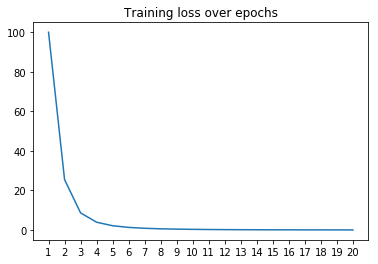

In [13]:
epochs = np.arange(1, 21, 1)
plt.plot(epochs, tr_losses)
plt.xticks(epochs, epochs)
plt.title("Training loss over epochs")
plt.show()

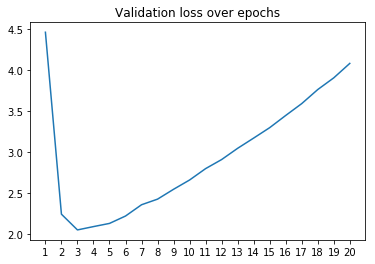

In [14]:
epochs = np.arange(1, 21, 1)
plt.plot(epochs, val_losses)
plt.xticks(epochs, epochs)
plt.title("Validation loss over epochs")
plt.show()

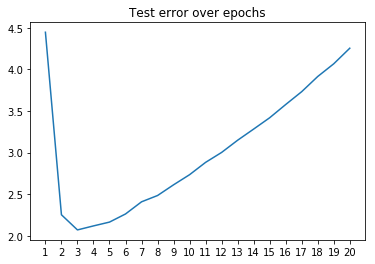

In [15]:
epochs = np.arange(1, 21, 1)
plt.plot(epochs, test_losses)
plt.xticks(epochs, epochs)
plt.title("Test error over epochs")
plt.show()